<a href="https://colab.research.google.com/github/annajli/gaussian_processes/blob/main/Gaussian_Processes_Visualizing_Kernel_Choices_Using_Bayesian_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Processes - Visualizing Kernel Choices Using Bayesian Linear Regression

The formal definition of a **Gaussian process** is: an infinite collection of random variables, any finite number of which are jointly Gaussian.

## Table of Contents
1. Bayesian Linear Feature Regression (Weight Space View)
2. Bayesian Linear Regression as a Gaussian Process (Function Space View)
3. Random Fourier Feature Approximation 

## Bayesian Linear Feature Regression

In linear regression or ordinary least squares (OLS), we find the best $\textbf{w}$ that fits: 

$$y = X\textbf{w}$$

where labels 
$y \in \mathbb{R}^N$, training points $X \in \mathbb{R}^{N x D}$, and weight vector $\textbf{w} \in \mathbb{R}^D$. 

Often times our data is non-linear so we make the model more flexible with $M$ fixed basis functions that make up the feature map $\Phi$. 
This turns our new objective function into:

$$y = \Phi(X)\textbf{w}$$

where $\Phi(X) \in \mathbb{R}^{N x M}, \Phi(X) = [\phi_1(X) ... \phi_M(X)]^T$ 

At a high level, our map $\Phi$ lifts our data to a higher dimension then we can use a standard method to find a hyperplane that best fits our data.

Now for Bayesian Linear Regression, we assume a prior on our weights $\textbf{w}$, namely assume:

$$p(\textbf{w}) = N(\textbf{w} | 0, \alpha^{-1}\textbf{I})$$

This prior on $\textbf{w}$ is imperative for the notion of a Gaussian Process. Recall that a GP is a collection of random variables, and in the
formal definition, a random variable is also a function. Therefore a GP is also a $\textit{distribution of functions}$. This is exactly what the prior on $\textbf{w}$ provides.
Namely, each choice of $\textbf{w}$ gives us a function of $\textbf{x}$. 

Note: This is the general framework for Bayesian Polynomial Regression that we did in Homework 2.

In [ ]:
### Import basic libraries
import math
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

In [ ]:
def generate_toy_data(n_points=20, noise_std=0.05):
    ''' Function to generate a toy dataset '''
    x = np.linspace(-5, 5, n_points)
    x_test = np.linspace(-5, 5, 50)

    #define a function relating input to output
    f = lambda x: 0.01 * x**3

    #generate noisy training labels
    y = f(x) + np.array([np.random.normal(0, noise_std * x_n**2) for x_n in x])
    y_test = f(x_test) + np.array([np.random.normal(0, noise_std * x_n**2) for x_n in x_test])
    
    return x, y, x_test, y_test

## Bayesian Linear Regression as a Gaussian Process

### Weight-Space View

ANNA TODO: do weight space view by using kernel trick for feature map and show computation speed up

### Function-Space View

In [ ]:
# Generate a data set for doing regression
x_train, y_train, x_test, y_test = generate_toy_data(n_points=200) 

In [ ]:
# defining our kernel to be the SE (RBF) kernel in 1D
# with hyperparameters:
# - length scale l
# - signal variance sigma_f
# - noise variance sigma_n  
def computeRBFKernel(p, q, x_p, x_q, l, sigma_f, sigma_n):
  if (p == q): 
    return sigma_f**2 * math.exp((-1/(2 * l**2)) * (x_p - x_q)**2) + sigma_n**2
  else:
    return sigma_f**2 * math.exp((-1/(2 * l**2)) * (x_p - x_q)**2)

def computeJointRBFKernel(x, x_star, l, sigma_f, sigma_n):
  n = x.size
  N = x_star.size
  matrix = np.empty([n, N])

  for i in range(n):
    for j in range(N):
      matrix[i, j] = computeRBFKernel(i, j, x[i], x_star[j], l, sigma_f, sigma_n)
  return matrix

In [ ]:
# simple baby example
# assume mean = 0
# hyperparameters 
l = 1
sigma_f = 1
sigma_n = 0.1

x_vals = np.linspace(-5, 5, num = 25)

prior_kernel = computeJointRBFKernel(x_vals, x_vals, l, sigma_f, sigma_n)

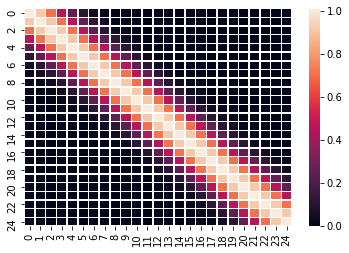

In [ ]:
# RBF Kernel with 25 uniformly spaced points from [-5, 5]
ax = sns.heatmap(prior_kernel, linewidth=0.5)
plt.show()

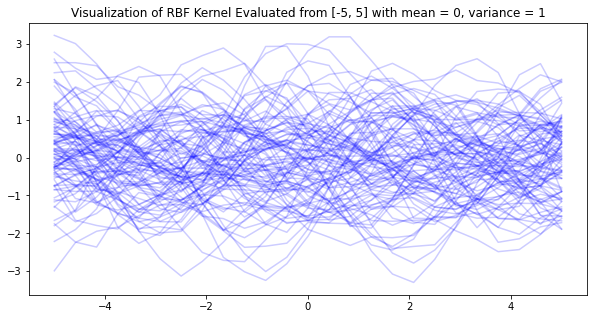

In [ ]:
# sample
prior_samples = []
# sample 100 times
for i in range(100):
  prior_samples.append(np.random.multivariate_normal(np.zeros(len(x_vals)), prior_kernel))

# visualize results
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # make a figure with one row and one column of size 10x5

# Plot the prior samples
for sample in prior_samples:
  ax.plot(x_vals, sample, color='blue', alpha=0.2)

ax.set_title('Visualization of RBF Kernel Evaluated from [-5, 5] with mean = 0, variance = {}'.format(sigma_f))

plt.show() # display the figure

**Review**:
1. We are interested in predicting the function values for 25 different x values, uniformly spaced in the interval [-5, 5] without knowing about training points. In GPs we treat each test points as a random variable. 

2. The covariance matrix is created by pairwise evaluation of the kernel function resulting in a 25 x 25 matrix. The kernel we chose for this example is the RBF (Radial Basis Function) kernel. 

3. Making a prediction using a GP is just drawing samples from a distribution. We sampled from a multivariate Gaussian with mean 0 and variance equal to the covariance matrix described above and obtained a 25-dimensional vector where each entry $i$ represents the function value corresponding to the $i$-th test point. 

---
## Posterior Distribution

Recall that we assume a Bayesian Linear Regression Model $f(x) = \phi(X)^Tw$ with prior $w \sim N(0, \Sigma_p)$. 

Now we consider when we observe training data and see if we can incorporate this additional information into our model.

We first form a join distribution $P_{f, f^*}$ between the test outputs $f^*$ and training outputs $f$. The result is a multivaraite Gaussian distribution with dimensions $|f| + |f^*|$. We can concatenate the training and test points to compute our desired covariance matrix. 

Notice that when we use conditioning, to find $P(f^* | f)$ from $P_{f, f^*}$, the new distribution is also Gaussian with dimension $N$ for the number of test points. *Note: conditioning leads to derived versions of the mean and SD. 

*Intuition:* The training points constrain the set of functions to those that pass through the training points. Before, a GP is infinite dimensional! But once we see training points, we scope the set of all possible functions to consider those that pass through the training points. 


**Prediction with Noise-free Observations**

The joint distribution of the training outputs and test outputs according to the prior is: 

$$
\begin{bmatrix} f \\ f^* \end{bmatrix} \sim N \left( 0, \begin{bmatrix} K(X, X) & K(X, X^*) \\ K(X^*, X) & K(X^*, X^*) \end{bmatrix} \right)
$$

To get the desired posterior distribution over functions, we need to restrict this joint prior distribution to contain only functions that agree with the observed data points. In other words, any GP prior has infinite dimension with mean and covariance function specified that models all possible functions. However, once we instantiate using our observed labels $f$, we constrain the space to only function values that agree with our training observations. 

We could generate functions from the prior and reject the ones that disagree with our observations but that is computationally inefficient. Instead, we *condition* the joint Gaussian prior distribution on the observations. 

Using **Proposition 8.5.1** in the Blitzstein Probability Book, 

For $X, Y$ jointly Gaussian r.v.s., 
$$
\begin{bmatrix} X \\ Y \end{bmatrix} \sim N \left( \begin{bmatrix} \mu_x \\ \mu_y \end{bmatrix}, \begin{bmatrix} A & C \\ C^T & D \end{bmatrix} \right)
$$

then
$$
X | Y \sim N(\mu_x + CB^{-1}(y - \mu_y), A - CB^{-1}C^T)
$$


$$=> 
f^* | X^*, X, f \sim N(K(X^*, X)K(X, X)^{-1}f, K(X^*, X^*) - K(X^*, X)K(X, X)^{-1}K(X, X^*))
$$

**Prior on our Test Points Having Not Seen Any Observations**

---




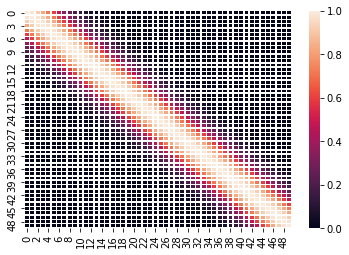

In [ ]:
# hyperparameters
# l controls how much variance I want in my distribution functions, more wiggly! 
# sigma_f about amplitude 
l = 1
sigma_f = 1

prior_kernel = computeJointRBFKernel(x_test, x_test, l, sigma_f, 0)
ax = sns.heatmap(prior_kernel, linewidth=0.5)
plt.show()

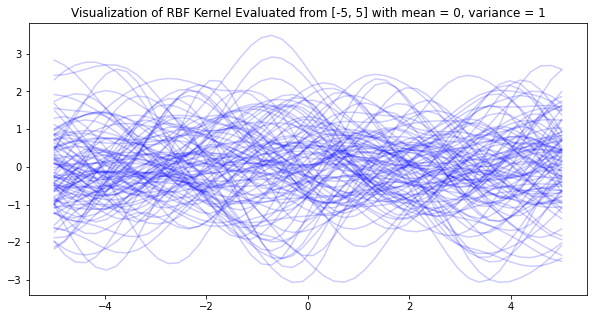

In [ ]:
# sample
prior_samples = []
# sample 100 times
for i in range(100):
  prior_samples.append(np.random.multivariate_normal(np.zeros(len(x_test)), prior_kernel))

# visualize results
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # make a figure with one row and one column of size 10x5

# Plot the prior samples
for sample in prior_samples: 
  ax.plot(x_test, sample, color='blue', alpha=0.2)

ax.set_title('Visualization of RBF Kernel Evaluated from [-5, 5] with mean = 0, variance = {}'.format(sigma_f))

plt.show() # display the figure

**Bayeisan Linear Regression with Noise Free Points**

---




ANNA TODO: generate noiseless perfect data from x^2 and see if theory holds.

In [ ]:
# Computes Mean and Variance of Conditional Distribution f* | X, X*, f
def computeMeanAndVariance(kernel, x, x_star, f, sigma_n=0):
  # use the mean and covariance dervied for the GP process for regression
  jointKernel_1 = kernel(x, x_star)
  jointKernel_2 = kernel(x_star, x)
  xTrainKernel = kernel(x, x)
  xTestKernel = kernel(x_star, x_star)

  # To Do add to sigma^2 identity

  # calculate mean and variance of GP regression
  # instead of naked matrix inversion use Cholesky of LU inversion
  gp_mean = jointKernel_2 @ np.linalg.inv(xTrainKernel + sigma_n**2 * np.identity(len(xTrainKernel))) @ f

  gp_variance = xTestKernel - jointKernel_2 @ np.linalg.inv(xTrainKernel + sigma_n**2 * np.identity(len(xTrainKernel))) @ jointKernel_1

  return gp_mean, gp_variance

In [ ]:
# add a bit of noise for numeric stability beacuse sometimes the covariance matrix will not be PSD
rbf_kernel = lambda x, x_star : computeJointRBFKernel(x, x_star, l, sigma_f, 10**-6)

In [ ]:
# noise free predictive distribution after constraining our GP prior with observations f
indices = np.array([101, 172,  20,  66, 170])
x_train_sub = x_train[indices]
y_train_sub = y_train[indices]

# the dimension of the mean and covariance matrix is the same number of test points we specify 

# For predictions, x_test should be even grid between (-5, 5)
x_grid = np.linspace(-5, 5, num=50)

gp_mean_rbf, gp_variance_rbf = computeMeanAndVariance(rbf_kernel, x_train_sub, x_grid, y_train_sub)

# sampling from our distribution and obtaining function values on test inputs
num_samples = 1000
y_preds = []

for i in range(num_samples):
  y_preds.append(np.random.multivariate_normal(gp_mean_rbf, gp_variance_rbf))

y_preds = np.array(y_preds)

# computing 95th percentile predictive intervals
y_pred_ub = np.percentile(y_preds, 97.5, axis = 0)
y_pred_mean = np.percentile(y_preds, 50.0, axis = 0)
y_pred_lb = np.percentile(y_preds, 2.5, axis = 0)

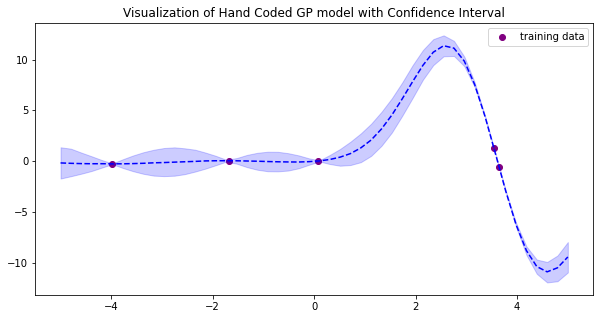

In [ ]:
# visualize results
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # make a figure with one row and one column of size 10x5
ax.scatter(x_train_sub, y_train_sub, label='training data', color='purple') # scatter plot the training data
# plot uncertainty between upper and lower bounds
ax.fill_between(x_grid, y_pred_ub, y_pred_lb, color='blue', alpha=0.2)

# # Plot the predictive samples
ax.plot(x_grid.flatten(), y_pred_mean, '--', color='blue')

ax.set_title('Visualization of Hand Coded GP model with Confidence Interval')
ax.legend(loc='best') # display legend
plt.show() # display the figure

**Analysis:** We see that the mean goes through all the training points and wherever there isn't training points, we have large amounts of uncertainty, as desired. Yay!

**Why is this expected?**
Well recall that our conditional Gaussian distribution is:

$$=> 
f^* | X^*, X, f \sim N(K(X^*, X)K(X, X)^{-1}f, K(X^*, X^*) - K(X^*, X)K(X, X)^{-1}K(X, X^*))
$$

At the training points, $X^* = X$: 

Mean: $K(X, X)K(X, X)^{-1}f = f$

Variance: $K(X, X) - K(X, X)K(X, X)^{-1}K(X, X) = K(X, X) - K(X, X) = 0$

So we see mathematically that at the training points, our prediction will just be the function value.


**Bayeisan Linear Regression with Noisy Points**

---

We now add noise $\sigma_n$ to our predictions. (TO DO ASK WEI WEI!! Note: you don't need to do this because our toy data was generated already with noise) This seems to do a lot better (probably to combat numerical instability and ensure that the covariance matrix is not singular)

ANNA TODO: add the new objective function with noise

$$=> 
f^* | X^*, X, f \sim N(K(X^*, X)K(X, X)^{-1}f, K(X^*, X^*) - K(X^*, X)K(X, X)^{-1}K(X, X^*))
$$

In [ ]:
# the sigma_n is added for numeric stability beacuse sometimes the covariance matrix will not be PSD
rbf_kernel = lambda x, x_star : computeJointRBFKernel(x, x_star, l, sigma_f, sigma_n)

In [ ]:
# noise predictive distribution after constraining our GP prior with observations f
# good practice: always add 10^-6 to your diagonal
gp_mean_rbf, gp_variance_rbf = computeMeanAndVariance(rbf_kernel, x_train, x_test, y_train, 0.5)

# sampling from our distribution and obtaining function values on test inputs
num_samples = 100
y_preds = []

for i in range(num_samples):
  y_preds.append(np.random.multivariate_normal(gp_mean_rbf, gp_variance_rbf))

y_preds = np.array(y_preds)

# computing 95th percentile predictive intervals
y_pred_ub = np.percentile(y_preds, 97.5, axis = 0)
y_pred_mean = np.percentile(y_preds, 50.0, axis = 0)
y_pred_lb = np.percentile(y_preds, 2.5, axis = 0)

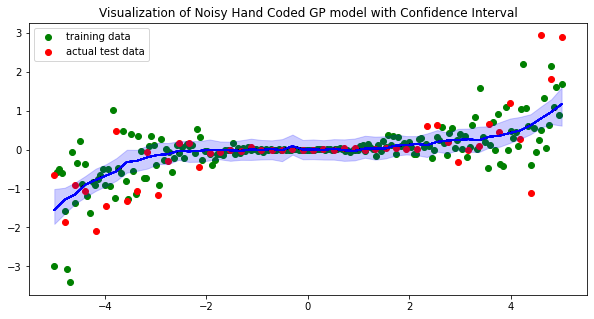

In [ ]:
# visualize results
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # make a figure with one row and one column of size 10x5
ax.scatter(x_train, y_train, label='training data', color='green') # scatter plot the training data
ax.scatter(x_test, y_test, label='actual test data', color='red') # scatter plot the test data
ax.fill_between(x_test, y_pred_ub, y_pred_lb, color='blue', alpha=0.2)

# Plot the predictive samples
for y_pred in y_preds:
    ax.plot(x_test, y_pred_mean, color='blue', alpha=0.2)

ax.set_title('Visualization of Noisy Hand Coded GP model with Confidence Interval')
ax.legend(loc='best') # display legend
plt.show() # display the figure

**GP Using SKLearn**

---
We compare our implementation of Bayesian Linear Regression using a GP with the industry standard sklean implementation

In [ ]:
# what it should look like 
import sklearn.gaussian_process as gp

# kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1)
kernel = gp.kernels.RBF(1)
# model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
model = gp.GaussianProcessRegressor(kernel=kernel, alpha = 0.1, optimizer=None)
model.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
params = model.kernel_.get_params()
print(params)

y_pred, cov_matrix = model.predict(x_test.reshape(-1, 1), return_cov=True)

# sample 100 times
y_pred_samples = []
for i in range(100):
  y_pred_samples.append(np.random.multivariate_normal(y_pred.reshape(len(y_pred)), cov_matrix))

{'length_scale': 1.0, 'length_scale_bounds': (1e-05, 100000.0)}


In [ ]:
y_pred_samples = np.array(y_pred_samples)

# computing 95th percentile predictive intervals
y_pred_ub = np.percentile(y_pred_samples, 97.5, axis = 0)
y_pred_mean = np.percentile(y_pred_samples, 50.0, axis = 0)
y_pred_lb = np.percentile(y_pred_samples, 2.5, axis = 0)

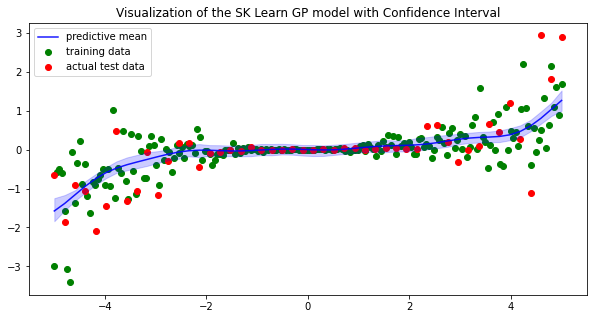

In [ ]:
# visualize results
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # make a figure with one row and one column of size 10x5
ax.scatter(x_train, y_train, label='training data', color='green') # scatter plot the training data
ax.scatter(x_test, y_test, label='actual test data', color='red') # scatter plot the test data
ax.fill_between(x_test, y_pred_ub, y_pred_lb, color='blue', alpha=0.2)

# Plot the predictions
ax.plot(x_test, y_pred, label='predictive mean', color='blue', alpha=0.9)

ax.set_title('Visualization of the SK Learn GP model with Confidence Interval')
ax.legend(loc='best') # display legend
plt.show() # display the figure

## Random Fourier Feature Approximation

We implement the Random Feature procedure of kernel machines as found in this paper:

https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf



### **Performance Concerns with True GPs**

In both the weight space view and the function space view, we did not explicity compute the feature map $\Phi$ and instead used the kernel trick. We conviniently
found a corresponding kernel function that represents the inner product of the feature map but in our original space. That way we apply the kernel function (which returns a scalar)
on all pairwise points in our training set to create the kernel matrix $\textbf{K} \in \mathbb{R}^{N x N}$ for $N$ number of training points. As you can see this imposes a quadratic 
dependence on the number of training points. 

For prediction, reacll the posterior mean of a GP is: 

$\mathbb{E}[\textbf{f}_*] = \textbf{K}(X_*, X)[\sigma^2\textbf{I} + \textbf{K}(X, X)]^{-1}\textbf{y} \in \mathbb{R}^n$. For $n$ number of test points.

In order to compute the mean vector, we have to $1)$ compute $\textbf{K}(X_*, X)$ which compares the test data against all the training points. 
$2)$ invert $\textbf{K}(X, X)$ an $N$ x $N$ matrix. (which is notoriously known for being computationally inefficient)

Even though we avoid directly computing $\Phi$ in higher dimensional space $\mathcal{V}$, which in the case of finite dimensional $\Phi$ saves us $NJ$ preprocess operations just to lift points into $J$ dimensions, and
makes possible for inference in an infinite dimensional feature space in other cases, even with the kernel trick, we are still stuck in $\mathbb{R}^N$. 
As we've seen consistently in this course, scaling depending on the number of training points is severly impractical. 

**Scalability for Mobile Health Space:**

\# of users (e.g. 110) * 5 times a day * 9 months $\approx $

### **Proposal for Efficiency Gains**

In Rahimi and Recht's 2007 paper on Random Features for Large-Scale Kernel Machines, they propose mapping input data to a randomized low-dimensional feature space and then apply existing fast linear methods. 

The randomized low-dimensinoal feature space is an approximation of the **kernel function** and *not* the kernel matrix like many others works.

They show for large-scale classification and regression tasks that this approximation method outperforms state of the art large scale kernel machines. 

As we saw earlier, the following theorem guarantees that we are able to find a corresponding positive definite kernel for any feature map $\Phi$:

**Mercer's Theorem**: Any positive definite function $k(x_n, x_m)$ with $x_n, x_m \in \mathbb{R}^d$ defines an inner product of another vector space $\mathcal{V}$. 

We now approximate the kernel with the inner product of a low-dimensional vector $z(x)$.

### **Approximating Kernel:**

$$k(x, x') = \Phi(x)^T\Phi(x') = \langle \Phi(x), \Phi(x') \rangle_{\mathcal{V}} \approx z(x)^Tz(y)$$ 

for $\textbf{z}: \mathbb{R}^d \rightarrow \mathbb{R}^D$ (low-dimensional $D$)

### **Fast Evaluations of the Machine**

*Evaluation Using Direct Kernel*
Evaluating one test point $x^*$ requires computing the kernel function for $x^*$ against all training points $x$. 

$f(x^*) = \sum_{i = 1}^{N} c_ik(x_i, x^*)$

since the dimension of $x$ and $x^*$ is $d$, that means for each evaluation of $f(x^*)$, we have $O(Nd)$ total computations which is unacceptable for large $N$. 

*Evaluation Using Approximated Kernel*
On the other hand, after learning a hyperplane $w$, a linear machine is evaluated:

$f(x^*) = w^Tz(x)$

which requires only $O(D + d)$ operations and storage.

### **Proof of Precision Guarantees of Approximation**

Show how to Construct Feature Spaces That Uniformly Approximate Stationary Kernels to Within $\epsilon$ Accuracy with only $D = O(d\epsilon^{-2}\log(\frac{1}{\epsilon^2}))$ dimensions. 

### **Random Fourier Features Algorithm**

We require a positive definite shift-invariant kernel $k(x, y) = k(x - y)$ and ensure a randomized feature map $\textbf{z}(x): \mathbb{R}^d \rightarrow \mathbb{R}^D$ (low-dimensional $D$) so that $k(x, x') \approx z(x)^Tz(y)$

\begin{align}
\phi: \mathbb{R}^{D'} &\to \mathbb{R}^D\\
\mathbf{x} &\mapsto \left[\sqrt{\frac{2}{D}} \cos(w_1^\top x + b_1), \ldots, \sqrt{\frac{2}{D}} \cos(w_D^\top x + b_D)\right]
\end{align}
<br>where $b_d \sim [0, 2\pi]$ and $w_d \sim \mathcal{N}(0, \beta I_{D'\times D'})$ need to be randomly sampled and fixed before modeling and inference.

### **How Does $k(x, x') \approx z(x)^Tz(y)$**

$$
z(x)^Tz(y) = \frac{1}{D} \sum_{i = 1}^{D} z_{W_i}(x) * z_{W_i}(y)
$$

$$
= \frac{1}{D} \sum_{i = 1}^{D} 2cos(W_i^Tx + b_i) * 2cos(W_i^Ty + b_i)
$$

$$
= \frac{1}{D} \sum_{i = 1}^{D} cos(W_i^T(x - y))
$$

$$
\approx \mathbb{E}_{w}[cos(W^T(x - y))]
$$

$$
= \int p(w) * cos(W^T(x - y)) dw
$$

$$
= k(x, y)
$$

My hypothesis is that if we increase the dimension $D$ of the feature space, I will get a better approximation of my kernel function.

In [ ]:
def compute_z(X, beta, D):
  # draw D samples of w from normal
  w = np.random.normal(0, beta**0.5, size=(D, 1)) 
  # draw D samples of b from uniform 
  b = np.random.uniform(0, 2 * np.pi, size=(D, 1))
  z_x = np.sqrt(2. / D)* np.cos(w.dot(X.reshape((1, -1))) + b)

  return z_x

In [ ]:
def get_posterior_samples(prior_var, noise_var, x_matrix, y_matrix, x_test_matrix, samples=100):
    '''Function to generate posterior predictive samples for Bayesian linear regression model'''
    prior_variance = np.diag(prior_var * np.ones(x_matrix.shape[1]))
    prior_precision = np.linalg.inv(prior_variance)

    joint_precision = prior_precision + x_matrix.T.dot(x_matrix) / noise_var
    joint_variance = np.linalg.inv(joint_precision)
    joint_mean = joint_variance.dot(x_matrix.T.dot(y_matrix)) / noise_var

    #sampling 100 points from the posterior
    posterior_samples = np.random.multivariate_normal(joint_mean.flatten(), joint_variance, size=samples)

    #take posterior predictive samples
    posterior_predictions = np.dot(posterior_samples, x_test_matrix.T) 
    posterior_predictive_samples = posterior_predictions[np.newaxis, :, :] + np.random.normal(0, noise_var**0.5, size=(100, posterior_predictions.shape[0], posterior_predictions.shape[1]))
    posterior_predictive_samples = posterior_predictive_samples.reshape((100 * posterior_predictions.shape[0], posterior_predictions.shape[1]))
    return posterior_predictions, posterior_predictive_samples

In [ ]:
def computePosteriorPredictiveConfidence(x_train_rff, x_test_rff, y_train, alpha):
  # compute posterior predictive samples
  prior_var = 1
  noise_var = 0.3

  posterior_preds, posterior_pred_samples = get_posterior_samples(alpha * prior_var, noise_var, x_train_rff, y_train.reshape(-1, 1), x_test_rff)  
  posterior_pred_ub = np.percentile(posterior_pred_samples, 97.5, axis=0)
  posterior_pred_lb = np.percentile(posterior_pred_samples, 2.5, axis=0)
  posterior_pred_mean = np.percentile(posterior_pred_samples, 50.0, axis=0)

  return posterior_pred_ub, posterior_pred_lb, posterior_pred_mean

In [ ]:
beta = 10
D = [1, 5, 10, 100, 500, 1000]
x_train_rffs = [compute_z(x_train, beta, d).T for d in D]
x_test_rffs = [compute_z(x_test, beta, d).T for d in D]

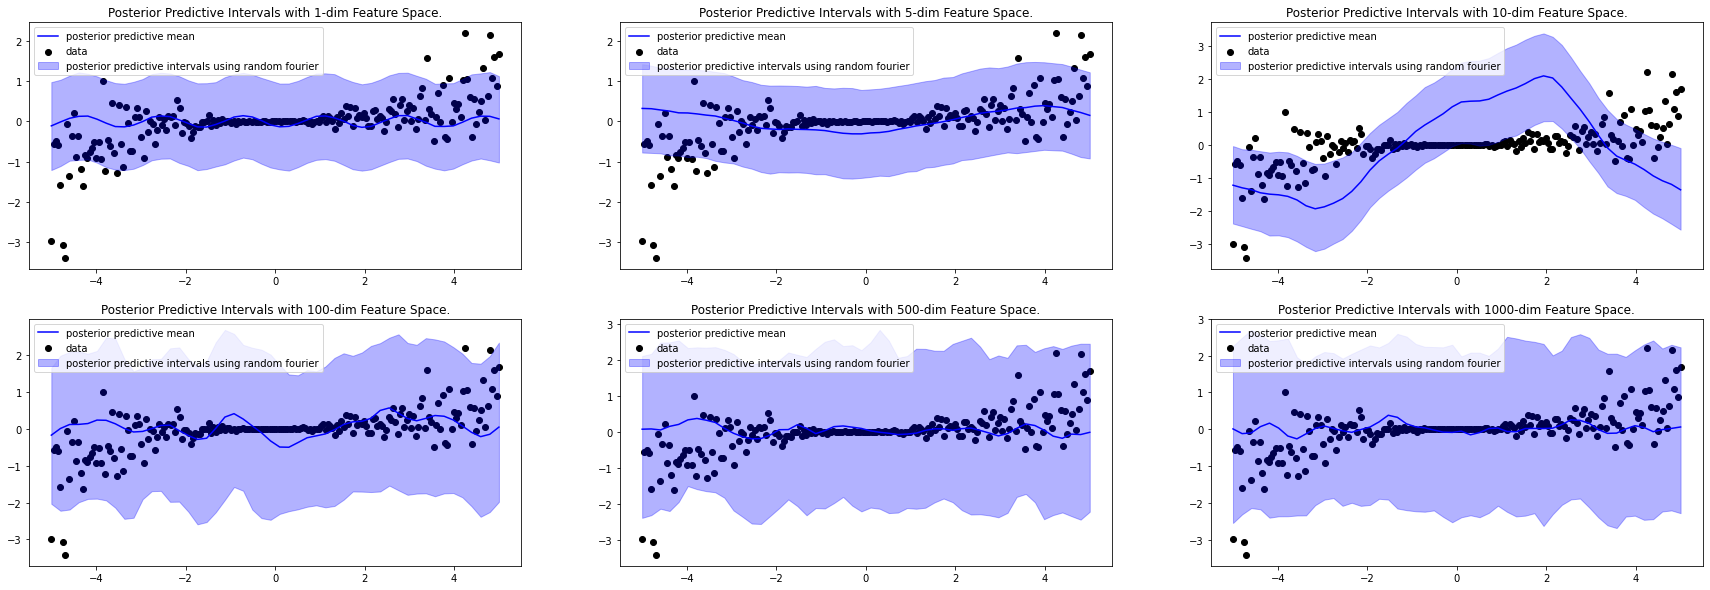

In [ ]:
ubs = []
lbs = []
posterior_means = []

for i in range(len(D)):
  x_train_rff = x_train_rffs[i]
  x_test_rff = x_test_rffs[i]
  posterior_pred_ub, posterior_pred_lb, posterior_pred_mean = computePosteriorPredictiveConfidence(x_train_rff, x_test_rff, y_train, 1)
  ubs.append(posterior_pred_ub)
  lbs.append(posterior_pred_lb)
  posterior_means.append(posterior_pred_mean)

# plot
fig, ax = plt.subplots(2, 3, figsize=(30, 10))

for i in range(len(D)):
  row = i // 3
  col = i % 3
  ax[row, col].scatter(x_train, y_train, color='black', label='data')
  ax[row, col].set_title('Posterior Predictive Intervals with {}-dim Feature Space.'.format(D[i]))
  ax[row, col].plot(x_test, posterior_means[i], color='blue', label='posterior predictive mean')
  ax[row, col].fill_between(x_test, ubs[i], lbs[i], color='blue', alpha=0.3, label='posterior predictive intervals using random fourier')
  ax[row, col].legend(loc='best')

plt.show()

# Resources
---

* **GP Regression:** http://gregorygundersen.com/blog/2019/06/27/gp-regression/

* **Visualization of GPs:** https://distill.pub/2019/visual-exploration-gaussian-processes

* **The Kernel Cookbook:** https://www.cs.toronto.edu/~duvenaud/cookbook/

* **SK Learn GP:** https://towardsdatascience.com/quick-start-to-gaussian-process-regression-36d838810319

* **Random Fourier Features:** http://gregorygundersen.com/blog/2019/12/23/random-fourier-features/#a4-alternative-random-fourier-features


# Appendix
---

## Useful Gaussian Identities


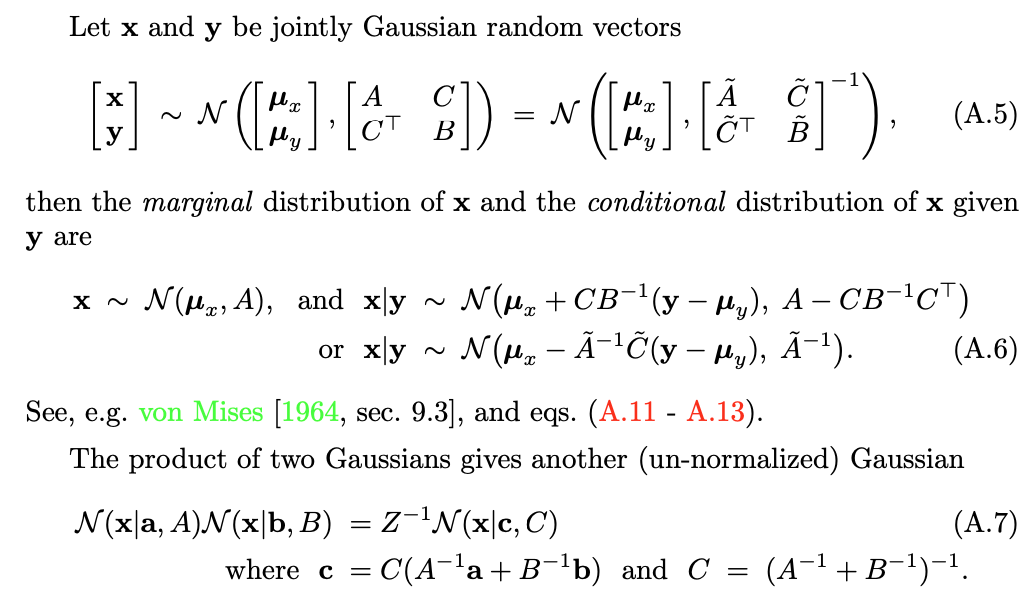

